In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import datetime, os
import random

import os
from tqdm import tqdm
import cv2
import seaborn as sn
import pandas as pd
import random as rn

In [2]:
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

In [3]:
labels = ['Human', 'Blank','Elephant_African', 'Hog_Red_River','Buffalo_African','Leopard_African','Monkey','Duiker_Blue','Duiker_Red','Porcupine_Brush_Tailed','Rodent','Squirrel','Rat_Giant','Guineafowl_Crested','Duiker_Yellow_Backed','Guineafowl_Black','Mongoose','Rail_Nkulengu','Mammal_Other','Chimpanzee','Bird','Genet','Gorilla','Pangolin','Mongoose_Black_Footed','Mandrillus','Civet_African_Palm','Chevrotain_Water','Cat_Golden']

In [4]:
label_count = {'Human': 34999, 'Blank': 35000, 'Elephant_African': 34999, 'Hog_Red_River': 26069, 'Buffalo_African': 6459, 'Leopard_African': 2142, 'Monkey': 5038, 'Duiker_Blue': 35000, 'Duiker_Red': 34999, 'Porcupine_Brush_Tailed': 13694, 'Rodent': 1358, 'Squirrel': 11348, 'Rat_Giant': 34225, 'Guineafowl_Crested': 1513, 'Duiker_Yellow_Backed': 15436, 'Guineafowl_Black': 12054, 'Mongoose': 5518, 'Rail_Nkulengu': 3269, 'Chimpanzee': 5260, 'Bird': 6649, 'Genet': 3303, 'Gorilla': 1074, 'Pangolin': 872, 'Mongoose_Black_Footed': 1475, 'Mandrillus': 9305, 'Civet_African_Palm': 936, 'Chevrotain_Water': 4713, 'Cat_Golden': 406}

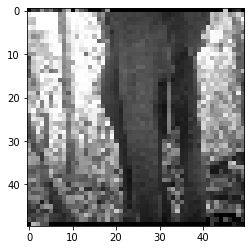

In [5]:
data = np.load("C:/Users/Siebren/Data_science/Data/Data_Gabon/training_data_gabon.npy", allow_pickle=True)
plt.imshow(data[2][0], cmap="gray")
plt.show()

In [6]:
# change duiker_blue and red to duiker
for picture in data:
    if picture[1] == 8:
        picture[1] = 7

In [7]:
other_animal_label = []
new_data = []
counter = {}
for picture in data:
    if label_count[labels[picture[1]]] < 5000 or picture[1] == 7 or picture[1] == 11 or picture[1] == 16:
        if picture[1] not in other_animal_label:
            other_animal_label.append(picture[1])
    else:
        if picture[1] in counter.keys():
            new_data.append(picture)
            counter[picture[1]] += 1
        else:
            new_data.append(picture)
            counter[picture[1]] = 1

In [8]:
# relabel data
new_labels = []
for key in counter.keys():
    new_labels.append(labels[key])                     
    
for item in new_data:
    item[1] = new_labels.index(labels[item[1]])

print(new_labels)

['Chimpanzee', 'Elephant_African', 'Hog_Red_River', 'Rat_Giant', 'Blank', 'Duiker_Yellow_Backed', 'Human', 'Guineafowl_Black', 'Porcupine_Brush_Tailed', 'Mandrillus', 'Bird', 'Monkey', 'Buffalo_African']


In [9]:
counter = {}
for key in other_animal_label:
    counter[key] = 0      

amount_of_pictures = 10000 // len(other_animal_label)
    
# append other animals
for picture in data:
    if picture[1] in other_animal_label:
        if counter[picture[1]] < amount_of_pictures:
            counter[picture[1]] += 1
            picture[1] = len(new_labels)
            new_data.append(picture)

new_labels.append("Other_animal")        
print(new_labels)

['Chimpanzee', 'Elephant_African', 'Hog_Red_River', 'Rat_Giant', 'Blank', 'Duiker_Yellow_Backed', 'Human', 'Guineafowl_Black', 'Porcupine_Brush_Tailed', 'Mandrillus', 'Bird', 'Monkey', 'Buffalo_African', 'Other_animal']


In [10]:
# random shuffle list. 
random.shuffle(new_data)

In [11]:
def create_set(new_data, amount):
    data = []
    second_count = {}
    count = 0
    for item in new_data:
        if item[1] in second_count.keys():
            if second_count[item[1]] >= amount:
                pass
            else:
                data.append(new_data.pop(count))
                second_count[item[1]] += 1
        else:
            data.append(new_data.pop(count))
            second_count[item[1]] = 1
        count += 1
        
    # Normalize pixel values to be between 0 and 1
    for pictures in data:
        pictures[0] = pictures[0] / 255

    return data

val_data = create_set(new_data, 2000)
test_data = create_set(new_data, 2000)

In [12]:
new_count = {}
for picture in new_data:
    if picture[1] in new_count.keys():
        new_count[picture[1]] += 1
    else:
        new_count[picture[1]] = 1
print(new_count)

{7: 7947, 3: 30225, 8: 9694, 2: 22069, 1: 30999, 4: 31000, 9: 5305, 5: 10816, 6: 30999, 13: 7202, 12: 2459, 0: 1260, 11: 828, 10: 2072}


In [13]:
# creates a data generator object that transforms images
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [14]:
# create empty dict and add data augmentation
count_train = {}
for key in new_count.keys():
    count_train[key] = 0

train_data = []
for picture in tqdm(new_data):
    if new_count[picture[1]] >= 10000:
        if count_train[picture[1]] < 10000:
            train_data.append(picture)
            count_train[picture[1]] += 1
    else:
        if count_train[picture[1]] < 10000:
            train_data.append(picture)
            count_train[picture[1]] += 1
            
            img = image.img_to_array(picture[0])  # convert image to numpy arry
            img = img.reshape((1,) + img.shape)  # reshape image

            amount_of_augmentations = 10000 // new_count[picture[1]]
            i = 0
            for batch in datagen.flow(img):
                augment_image = tf.reshape(batch[0], picture[0].shape)
                train_data.append([augment_image, picture[1]])
                count_train[picture[1]] += 1
                i += 1
                if i >= amount_of_augmentations: 
                    break

# random shuffle list. 
random.shuffle(train_data)
                    
print(count_train)

100%|██████████| 192875/192875 [00:30<00:00, 6383.44it/s]

{7: 10000, 3: 10000, 8: 10000, 2: 10000, 1: 10000, 4: 10000, 9: 10000, 5: 10000, 6: 10000, 13: 10000, 12: 10000, 0: 10000, 11: 10010, 10: 10000}


In [15]:
# Normalize pixel values to be between 0 and 1
for pictures in train_data:
    pictures[0] = pictures[0] / 255

# train model

In [16]:
# get the labels
def get_labels(data):
    images, labels = [], []
    for items in data:
        images.append(items[0])
        labels.append(items[1])
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

X_train, y_train = get_labels(train_data)
X_val, y_val = get_labels(val_data)
X_test, y_test = get_labels(test_data)

In [17]:
print(len(new_labels))

14


In [18]:
# reduce dimentions
X_train = tf.expand_dims(X_train, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)
X_val = tf.expand_dims(X_test, axis=-1)
y_train = tf.expand_dims(y_train, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)
y_val = tf.expand_dims(y_test, axis=-1)

# set initializer
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

In [19]:
# creating the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:], padding="same", kernel_initializer=initializer, bias_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same", kernel_initializer=initializer, bias_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same", kernel_initializer=initializer, bias_initializer=initializer))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same", kernel_initializer=initializer, bias_initializer=initializer))

model.add(layers.Flatten())
# model.add(layers.Dropout(0.3))
model.add(layers.Dense(180, activation='relu', kernel_initializer=initializer, bias_initializer=initializer))

model.add(layers.Dense(len(new_labels), activation="softmax", kernel_initializer=initializer, bias_initializer=initializer))

model.summary()  # summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 180)               3

In [20]:
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# With tensorboard
history = model.fit(X_train, y_train, epochs=3, batch_size = 32,
                    validation_data=(X_val, y_val))

# With tensorboard
# history = model.fit(X_train, y_train, epochs=10, batch_size = 32,
#                     validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

Epoch 1/3
4376/4376 [==============================] - 318s 73ms/step - loss: 1.1267 - accuracy: 0.5950 - val_loss: 0.8924 - val_accuracy: 0.6999
Epoch 2/3
4376/4376 [==============================] - 308s 70ms/step - loss: 0.7515 - accuracy: 0.7308 - val_loss: 0.6728 - val_accuracy: 0.7829
Epoch 3/3
4376/4376 [==============================] - 309s 71ms/step - loss: 0.5826 - accuracy: 0.7893 - val_loss: 0.6091 - val_accuracy: 0.8092


Epoch 1/10
4376/4376 [==============================] - 271s 62ms/step - loss: 1.1267 - accuracy: 0.5950 - val_loss: 0.8924 - val_accuracy: 0.6999
Epoch 2/10
4376/4376 [==============================] - 265s 61ms/step - loss: 0.7515 - accuracy: 0.7308 - val_loss: 0.6728 - val_accuracy: 0.7829
Epoch 3/10
4376/4376 [==============================] - 264s 60ms/step - loss: 0.5826 - accuracy: 0.7893 - val_loss: 0.6091 - val_accuracy: 0.8092
Epoch 4/10
4376/4376 [==============================] - 264s 60ms/step - loss: 0.4544 - accuracy: 0.8367 - val_loss: 0.5446 - val_accuracy: 0.8423
Epoch 5/10
4376/4376 [==============================] - 264s 60ms/step - loss: 0.3495 - accuracy: 0.8744 - val_loss: 0.5664 - val_accuracy: 0.8470
Epoch 6/10
4376/4376 [==============================] - 264s 60ms/step - loss: 0.2652 - accuracy: 0.9063 - val_loss: 0.6006 - val_accuracy: 0.8612
Epoch 7/10
4376/4376 [==============================] - 263s 60ms/step - loss: 0.2052 - accuracy: 0.9279 - val_loss: 0.6175 - val_accuracy: 0.8705
Epoch 8/10
4376/4376 [==============================] - 264s 60ms/step - loss: 0.1647 - accuracy: 0.9429 - val_loss: 0.6756 - val_accuracy: 0.8684
Epoch 9/10
4376/4376 [==============================] - 264s 60ms/step - loss: 0.1386 - accuracy: 0.9528 - val_loss: 0.6807 - val_accuracy: 0.8764
Epoch 10/10
4376/4376 [==============================] - 265s 61ms/step - loss: 0.1188 - accuracy: 0.9601 - val_loss: 0.7123 - val_accuracy: 0.8746

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(test_acc)

875/875 [==============================] - 9s 11ms/step - loss: 0.7123 - accuracy: 0.8746
0.8745714426040649


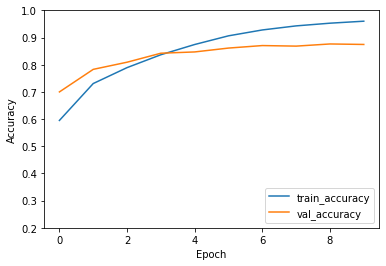

In [23]:
# plot results
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

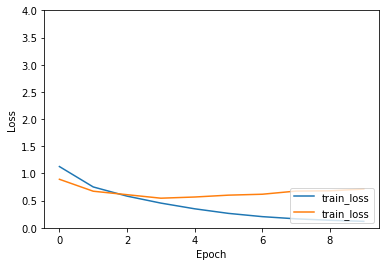

In [24]:
# plot results
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend(loc='lower right')

In [25]:
# score per class
Y_test = tf.reshape(y_test, [len(y_test)])
# Y_test = np.argmax(y_pred, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes()
y_pred = np.argmax(model.predict(X_test), axis=-1)

report = classification_report(Y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.round(decimals=2)
if new_labels[len(new_labels) -1] != "-":
    new_labels.extend(["-", "-", "-"])
df['label'] = new_labels
df

              precision    recall  f1-score   support

           0       0.94      0.80      0.86      2000
           1       0.79      0.85      0.82      2000
           2       0.89      0.92      0.91      2000
           3       0.86      0.93      0.89      2000
           4       0.81      0.89      0.85      2000
           5       0.84      0.96      0.89      2000
           6       0.88      0.84      0.86      2000
           7       0.94      0.96      0.95      2000
           8       0.89      0.87      0.88      2000
           9       0.93      0.98      0.96      2000
          10       0.88      0.87      0.88      2000
          11       0.94      0.80      0.87      2000
          12       0.97      0.87      0.92      2000
          13       0.73      0.70      0.72      2000

    accuracy                           0.87     28000
   macro avg       0.88      0.87      0.87     28000
weighted avg       0.88      0.87      0.87     28000



In [ ]:
df = pandas.DataFrame(report).transpose()
df

In [26]:
print(new_count)

{7: 7947, 3: 30225, 8: 9694, 2: 22069, 1: 30999, 4: 31000, 9: 5305, 5: 10816, 6: 30999, 13: 7202, 12: 2459, 0: 1260, 11: 828, 10: 2072}


In [27]:
print(new_labels)

['Chimpanzee', 'Elephant_African', 'Hog_Red_River', 'Rat_Giant', 'Blank', 'Duiker_Yellow_Backed', 'Human', 'Guineafowl_Black', 'Porcupine_Brush_Tailed', 'Mandrillus', 'Bird', 'Monkey', 'Buffalo_African', 'Other_animal']


<AxesSubplot:>

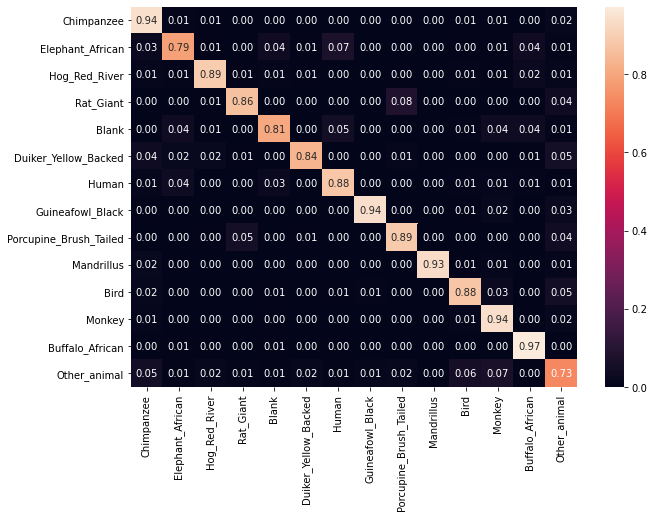

In [28]:
y_pred = model.predict(X_test)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for y in y_test], axis=0)
cm = confusion_matrix(predicted_categories, true_categories)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized

df_cm = pd.DataFrame(cmn, index = [i for i in new_labels],
                  columns = [i for i in new_labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.2f')

In [29]:
# model.save('Models/model_epoch20_more_classes.h5')

In [ ]:
# # Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('Models/model_epoch20_more_classes.tflite', 'wb') as f:
#     f.write(tflite_model)

In [52]:
# # clears session
# keras.backend.clear_session()

In [38]:
# new_model = tf.keras.models.load_model('Models/model_epoch20_more_classes.h5')
# new_model.summary()

# Test on myanmar data

0


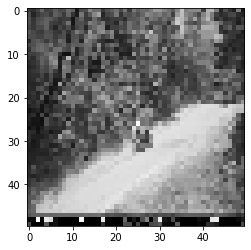

In [41]:
myanmar_data = np.load("C:/Users/Siebren/Data_science/Data/Data_Myanmar/testing_data_myanmar_for_gabon_model.npy", allow_pickle=True)
i = 2927
plt.imshow(myanmar_data[i][0], cmap="gray")
print(myanmar_data[i][1])
plt.show()

In [42]:
print(new_labels)

['Chimpanzee', 'Elephant_African', 'Hog_Red_River', 'Rat_Giant', 'Blank', 'Duiker_Yellow_Backed', 'Human', 'Guineafowl_Black', 'Porcupine_Brush_Tailed', 'Mandrillus', 'Bird', 'Monkey', 'Buffalo_African', 'Other_animal']


In [43]:
myan_original_labels = ["Cow", "Cow_cart", "Elephant_canopy_level", "Elephant_ground_level", "Poachers", "Truck", "Villagers", "Three_weel_cart"]

# change labels
for data in myanmar_data:
    if data[1] == 0:
        data[1] = new_labels.index("Human")
    elif data[1] == 1:
        data[1] = new_labels.index("Other_animal")
    elif data[1] == 2:
        data[1] = new_labels.index("Elephant_African")

print(f"Human label: " + str(new_labels.index("Human")))
print(f"Other label: " + str(new_labels.index("Other_animal")))
print(f"Elephant label: " + str(new_labels.index("Elephant_African")))

Human label: 6
Other label: 13
Elephant label: 1


In [44]:
pictures_myan = []
labels_myan = []

# Normalize pixel values to be between 0 and 1
for pic in myanmar_data:
    pic[0] = pic[0] / 255

for picture_myan, label_myan in myanmar_data:
    pictures_myan.append(picture_myan)
    labels_myan.append(label_myan)

In [45]:
pictures_myan = np.array(pictures_myan)
labels_myan = np.array(labels_myan)

pictures_myan = tf.expand_dims(pictures_myan, axis=-1)
labels_myan = tf.expand_dims(labels_myan, axis=-1)

In [46]:
test_loss, test_acc = model.evaluate(pictures_myan, labels_myan, verbose=1)
print(test_acc)

92/92 [==============================] - 1s 11ms/step - loss: 9.8131 - accuracy: 0.1291
0.12909835577011108


In [47]:
# score per class
Y_test = tf.reshape(labels_myan, [2928])
# Y_test = np.argmax(y_pred, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(pictures_myan)
# np.argmax(model.predict(pictures_myan), axis=-1)

print(classification_report(Y_test, y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.08      0.23      0.12        92
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.83      0.13      0.23      2562
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11     

C:\Users\Siebren\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
predictions = model.predict_on_batch(pictures_myan)

In [51]:
correct_zero, correct_one, correct_two = 0, 0, 0
for i in range(len(predictions)):
    if Y_test[i].numpy() != predictions[i].argmax():
        pass
#         print("correct: " + str(Y_test[i].numpy()) + " pred: " + str(predictions[i].argmax()))
#         print("---------------------")
    else:
        if Y_test[i].numpy() == new_labels.index("Human"):
            correct_zero += 1
        elif Y_test[i].numpy() == new_labels.index("Other_animal"):
            correct_one += 1
        elif Y_test[i].numpy() == new_labels.index("Elephant_African"):
            correct_two += 1

In [52]:
count_zero, count_one, count_two = 0, 0, 0
for label in labels_myan:
    if label == new_labels.index("Human"):
        count_zero += 1
    elif label == new_labels.index("Other_animal"):
        count_one += 1
    elif label == new_labels.index("Elephant_African"):
        count_two += 1
print("Human " + str(count_zero) + " / " + str(correct_zero))
print("Other_animal " + str(count_one) + " / " + str(correct_one))
print("Elephant_African " + str(count_two) + " / " + str(correct_two))

Human 2562 / 343
Other_animal 274 / 14
Elephant_African 92 / 21


<AxesSubplot:>

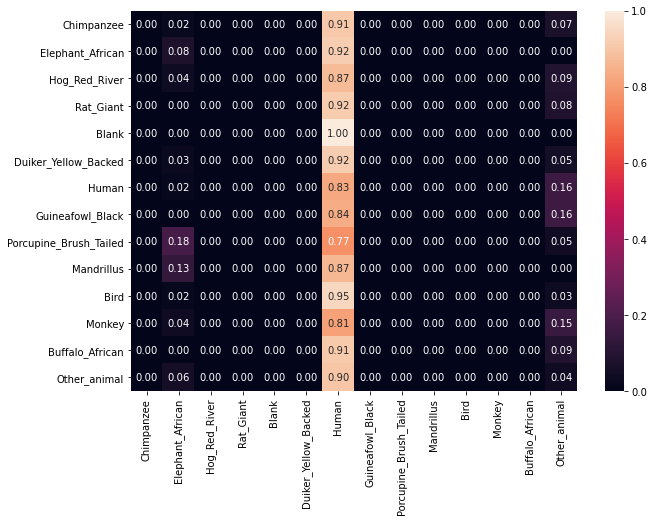

In [53]:
y_pred = model.predict(pictures_myan)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for y in labels_myan], axis=0)
cm = confusion_matrix(predicted_categories, true_categories)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized

df_cm = pd.DataFrame(cmn, index = [i for i in new_labels],
                  columns = [i for i in new_labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.2f')